In [0]:
from google.colab import files
files.upload()

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 327M/337M [00:05<00:00, 46.4MB/s]
100% 337M/337M [00:05<00:00, 68.0MB/s]


In [0]:
!unzip /content/cell-images-for-detecting-malaria.zip

In [6]:
import torch
x= torch.Tensor([5,3])
y = torch.Tensor([1,32])
x*y

tensor([ 5., 96.])

In [7]:
!pip install torchvision

In [12]:
path = '/content/cell_images'
import os
print(os.listdir(path))
for i in os.listdir(path):
  print(len(os.listdir(os.path.join(path,i))))

['Parasitized', 'Uninfected']
13780
13780


In [0]:
import torch
import torchvision
from torchvision import transforms,datasets

In [0]:
from tqdm import tqdm
import cv2
import numpy as np

In [32]:
os.listdir('/content/cell_images/Parasitized')[0]

'C137P98ThinF_IMG_20151005_160918_cell_78.png'

In [36]:
data = True
class infectedvsnot():
  IMG_SIZE = 50
  infected = '/content/cell_images/Parasitized'
  notinfected = '/content/cell_images/Uninfected'

  labels = {infected : 0,notinfected : 1}
  training_data = []
  
  infectedcount = 0
  notinfectedcount = 0

  def make_data(self):
    for label in self.labels:
      print(label)
      for f in tqdm(os.listdir(label)):
        if "png" in f:
          try:
            path = os.path.join(label, f)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
            self.training_data.append([np.array(img), np.eye(2)[self.labels[label]]]) 
            if label == self.infected:
                self.infectedcount += 1
            elif label == self.notinfected:
                self.notinfectedcount += 1
          except Exception as e:
            pass
        
    np.random.shuffle(self.training_data)
    np.save("training_data.npy", self.training_data)
    print('Cats:',infectedvsnot.infectedcount)
    print('Dogs:',infectedvsnot.notinfectedcount)  

if data:
    infect = infectedvsnot()
    infect.make_data()                        

  1%|          | 148/13780 [00:00<00:09, 1475.26it/s]

/content/cell_images/Parasitized


  1%|▏         | 185/13780 [00:00<00:07, 1841.86it/s]

/content/cell_images/Uninfected


100%|██████████| 13780/13780 [00:07<00:00, 1725.05it/s]


Cats: 0
Dogs: 0


In [39]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

27558


In [0]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

tensor([0., 1.])


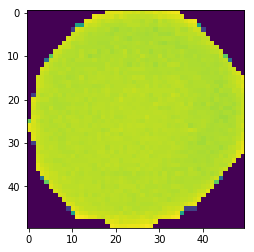

In [59]:
import matplotlib.pyplot as plt
print(y[0])
plt.imshow(X[0])


tensor([1., 0.])


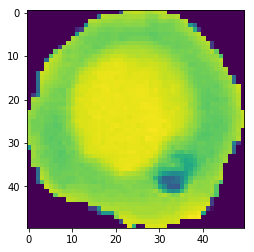

In [61]:
import matplotlib.pyplot as plt
print(y[3])
plt.imshow(X[3])


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2) # 512 in, 2 out bc we're doing 2 classes 

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [0]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [0]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [54]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

2755


In [0]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

In [56]:
print(len(train_X), len(test_X))

24803 2755


In [57]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|██████████| 249/249 [01:52<00:00,  2.22it/s]

Epoch: 0. Loss: 0.012723736464977264


In [58]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2755/2755 [00:06<00:00, 452.58it/s]

Accuracy:  0.839
